In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Dataset

In [2]:
data = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')
data.head()

,id,Marital status,Application mode,Application order,Course,Daytime/evening attendance,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,0,1,1,1,9238,1,1,126.0,1,1,...,0,6,7,6,12.428571,0,11.1,0.6,2.02,Graduate
1,1,1,17,1,9238,1,1,125.0,1,19,...,0,6,9,0,0.000000,0,11.1,0.6,2.02,Dropout
2,2,1,17,2,9254,1,1,137.0,1,3,...,0,6,0,0,0.000000,0,16.2,0.3,-0.92,Dropout
3,3,1,1,3,9500,1,1,131.0,1,19,...,0,8,11,7,12.820000,0,11.1,0.6,2.02,Enrolled
4,4,1,1,2,9500,1,1,132.0,1,19,...,0,7,12,6,12.933333,0,7.6,2.6,0.32,Graduate


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76518 entries, 0 to 76517
Data columns (total 38 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   id                                              76518 non-null  int64  
 1   Marital status                                  76518 non-null  int64  
 2   Application mode                                76518 non-null  int64  
 3   Application order                               76518 non-null  int64  
 4   Course                                          76518 non-null  int64  
 5   Daytime/evening attendance                      76518 non-null  int64  
 6   Previous qualification                          76518 non-null  int64  
 7   Previous qualification (grade)                  76518 non-null  float64
 8   Nacionality                                     76518 non-null  int64  
 9   Mother's qualification                 

To understand the values of categorical variables, i recommend you to examine the dataset from [here](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success). 

In [4]:
data.isnull().sum().any()

False

In [5]:
def get_variable_groups(data):
    cat_variables = ['Application order', 'Marital status',  'Daytime/evening attendance', 'Nacionality', 'Displaced',
                 'Educational special needs', 'Debtor', 'Tuition fees up to date', 'Gender',
                 'Scholarship holder', 'International']

    categorical_features_large = ['Application mode', 'Course', 'Previous qualification', "Mother's qualification",
                                  "Father's qualification", "Mother's occupation", "Father's occupation"]

    num_variables = [var for var in data.columns if var not in cat_variables + categorical_features_large and var not in ['Target', 'id']]
    
    return cat_variables, categorical_features_large, num_variables

In [6]:
cat_variables, categorical_features_large, num_variables = get_variable_groups(data)

In [7]:
print(f'Categorical Features (Count = {len(cat_variables)}):')
print('-'*30)
cat_variables

Categorical Features (Count = 11):
------------------------------


['Application order',
 'Marital status',
 'Daytime/evening attendance',
 'Nacionality',
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'International']

In [8]:
print(f'Categorical Features with large set of unique values (Count = {len(categorical_features_large)}):')
print('-'*30)
categorical_features_large

Categorical Features with large set of unique values (Count = 7):
------------------------------


['Application mode',
 'Course',
 'Previous qualification',
 "Mother's qualification",
 "Father's qualification",
 "Mother's occupation",
 "Father's occupation"]

In [9]:
print(f'Numerical Features (Count = {len(num_variables)}):')
print('-'*30)
num_variables

Numerical Features (Count = 18):
------------------------------


['Previous qualification (grade)',
 'Admission grade',
 'Age at enrollment',
 'Curricular units 1st sem (credited)',
 'Curricular units 1st sem (enrolled)',
 'Curricular units 1st sem (evaluations)',
 'Curricular units 1st sem (approved)',
 'Curricular units 1st sem (grade)',
 'Curricular units 1st sem (without evaluations)',
 'Curricular units 2nd sem (credited)',
 'Curricular units 2nd sem (enrolled)',
 'Curricular units 2nd sem (evaluations)',
 'Curricular units 2nd sem (approved)',
 'Curricular units 2nd sem (grade)',
 'Curricular units 2nd sem (without evaluations)',
 'Unemployment rate',
 'Inflation rate',
 'GDP']

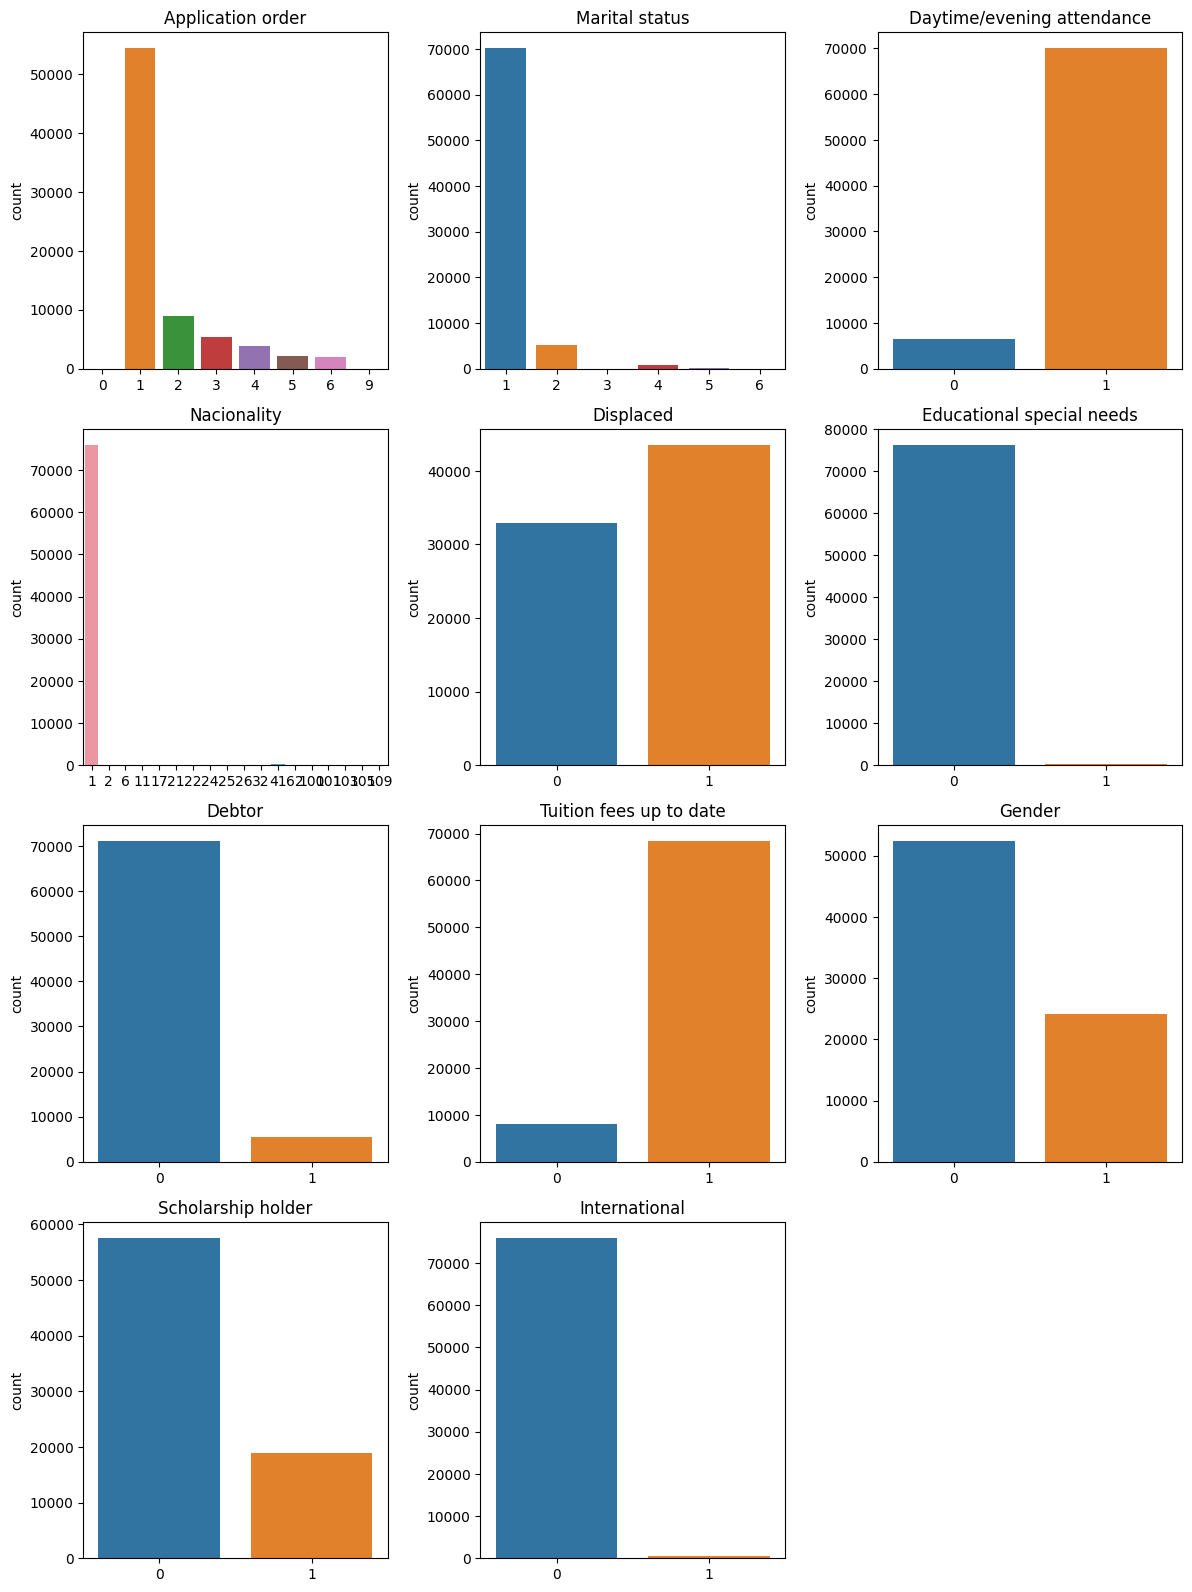

In [10]:
fig = plt.figure(figsize=(12, 16))

for idx, var in enumerate(cat_variables):
    plt.subplot(4, 3, idx+1)
    sns.countplot(data=data, x=var)
    plt.xlabel('')
    plt.title(var)

fig.tight_layout(pad=1.0)

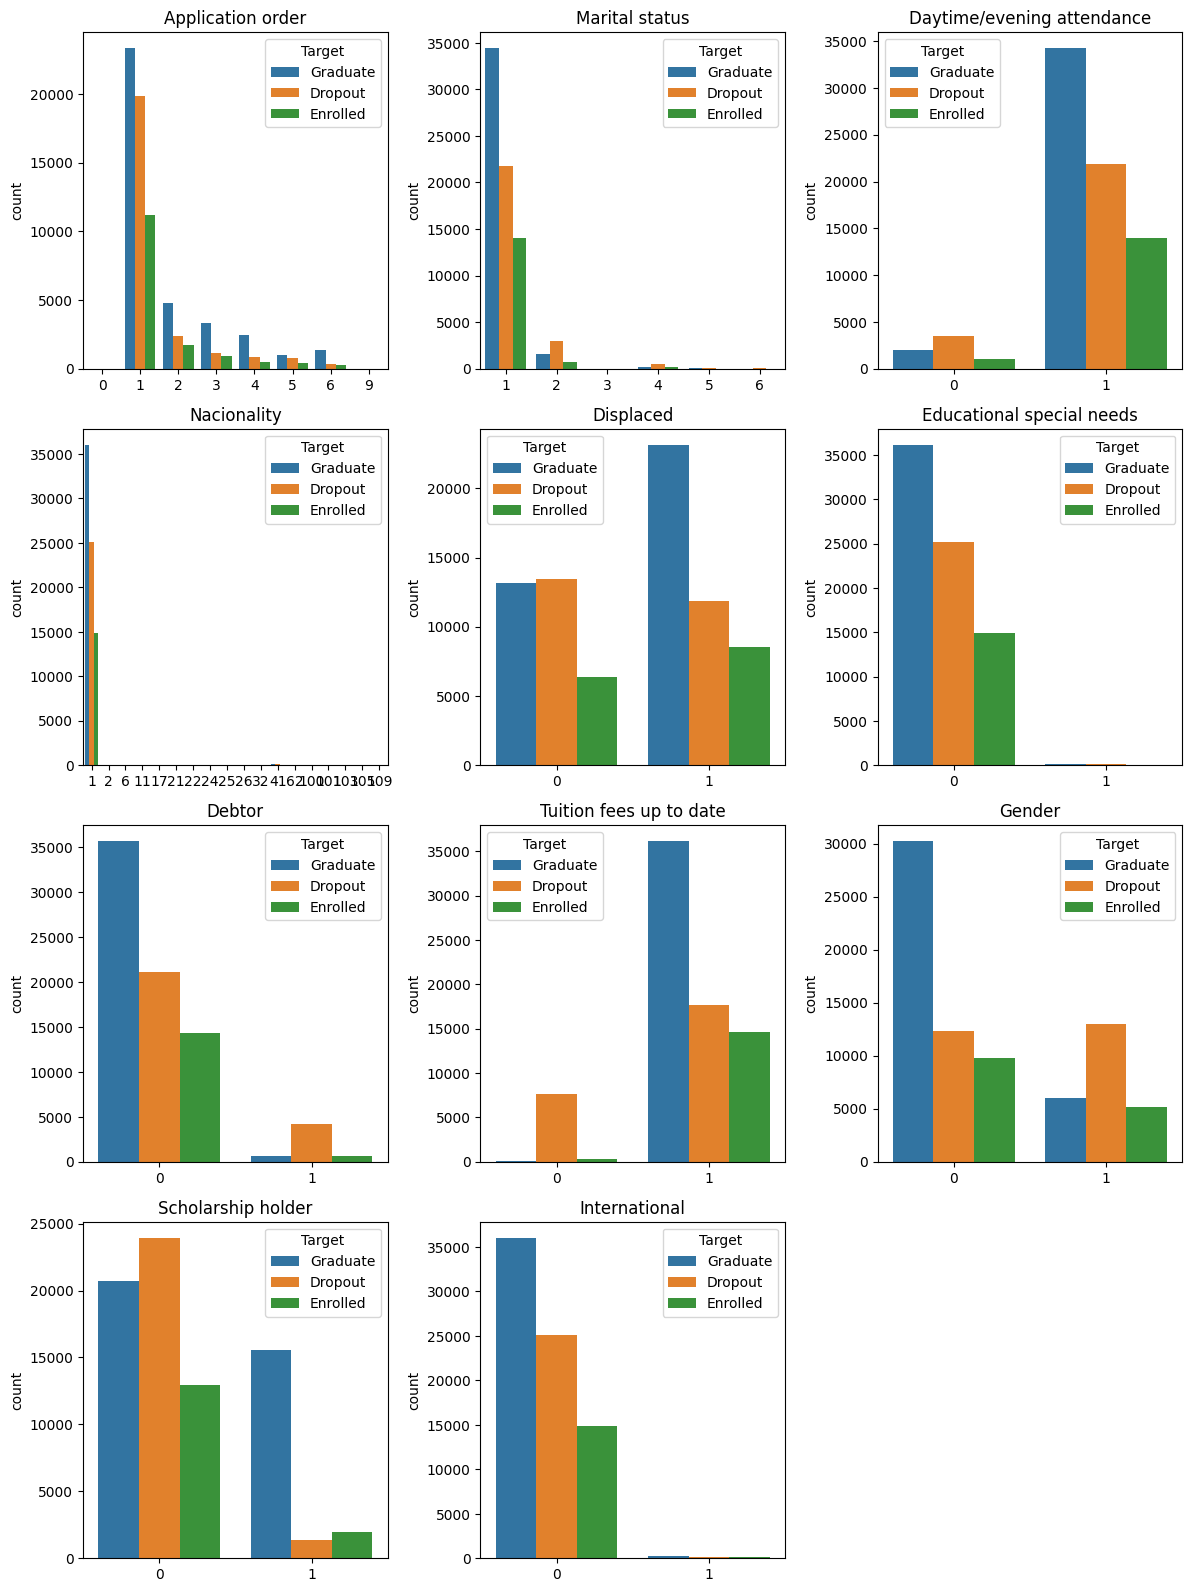

In [11]:
fig = plt.figure(figsize=(12, 16))

for idx, var in enumerate(cat_variables):
    plt.subplot(4, 3, idx+1)
    sns.countplot(data=data, x=var, hue='Target')
    plt.xlabel('')
    plt.title(var)

fig.tight_layout(pad=1.0)

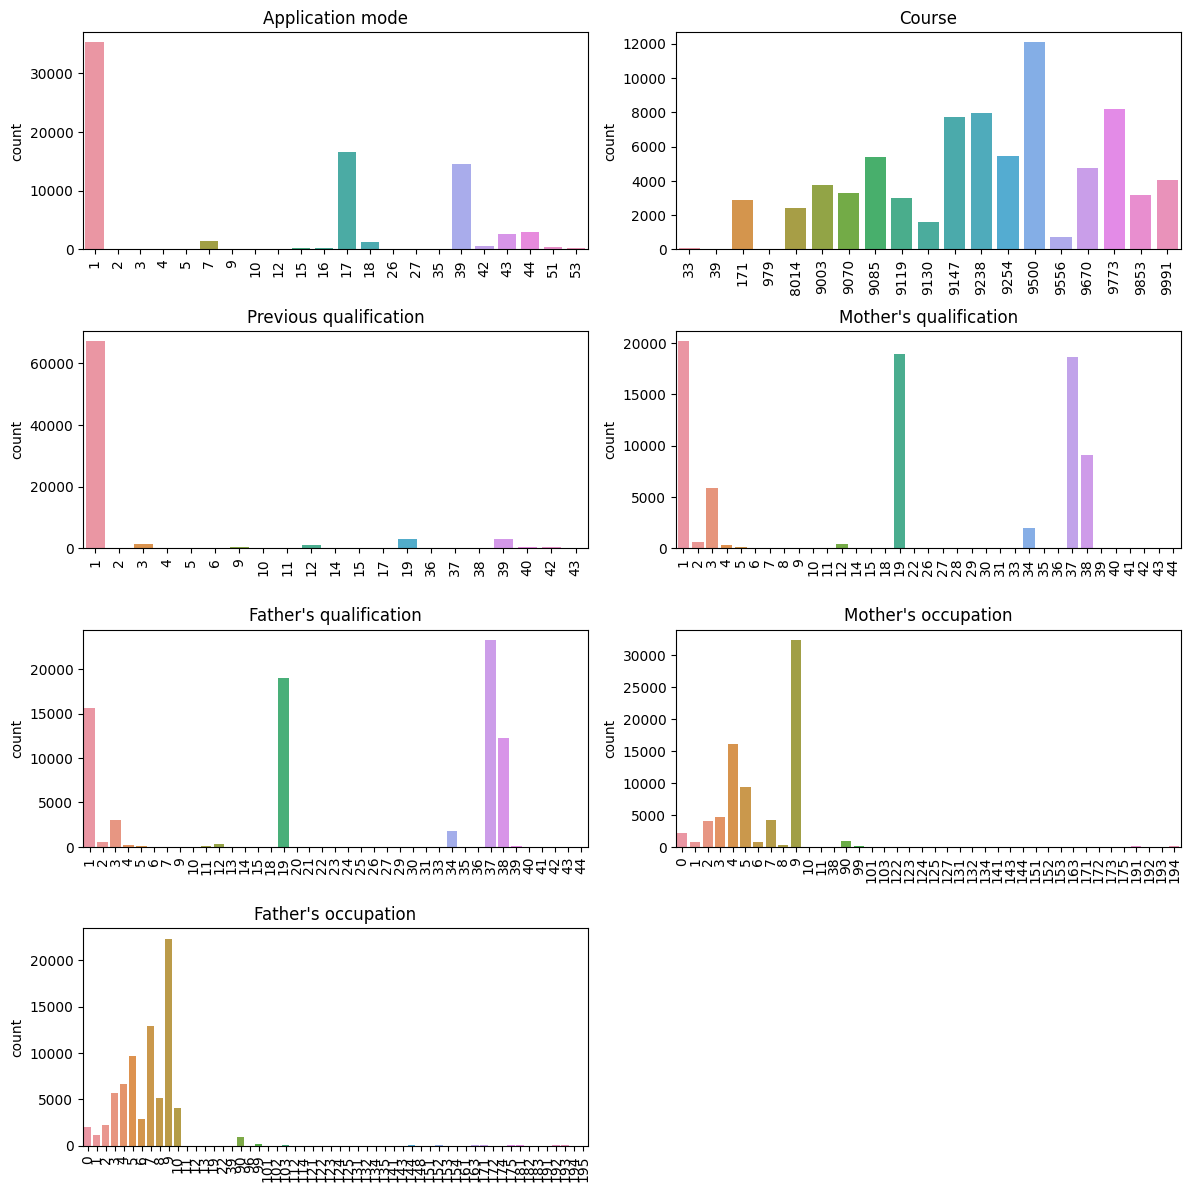

In [12]:
fig = plt.figure(figsize=(12, 12))

for idx, var in enumerate(categorical_features_large):
    plt.subplot(4, 2, idx+1)
    sns.countplot(data=data, x=var)
    plt.xticks(rotation=90)
    plt.xlabel('')
    plt.title(var)

fig.tight_layout(pad=1.0)

In [13]:
qualification_mapping = {
    1: "Secondary Education - 12th Year of Schooling or Eq.",
    2: "Higher Education - Bachelor's Degree",
    3: "Higher Education - Degree",
    4: "Higher Education - Master's",
    19: "Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv.",
    34: "Unknown",
    37: "Basic Education 1st Cycle (4th/5th Year) or Equiv.",
    38: "Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv.",
    12: "Other - 11th Year of Schooling",
    39: "Technological specialization course"
}

occupation_mapping = {
    0: "Student",
    1: "Representatives of the Legislative Power and Executive Bodies, Directors, Directors and Executive Managers",
    2: "Specialists in Intellectual and Scientific Activities",
    3: "Intermediate Level Technicians and Professions",
    4: "Administrative staff",
    5: "Personal Services, Security and Safety Workers and Sellers",
    6: "Farmers and Skilled Workers in Agriculture, Fisheries and Forestry",
    7: "Skilled Workers in Industry, Construction and Craftsmen",
    8: "Installation and Machine Operators and Assembly Workers",
    9: "Unskilled Workers",
    10: "Armed Forces Professions",
    90: "Other Situation",
    99: "(blank)",
    191: "Cleaning workers"
}

application_mode_mapping = {
    1: "1st phase - general contingent",
    2: "Ordinance No. 612/93",
    5: "1st phase - special contingent (Azores Island)",
    7: "Holders of other higher courses",
    10: "Ordinance No. 854-B/99",
    15: "International student (bachelor)",
    16: "1st phase - special contingent (Madeira Island)",
    17: "2nd phase - general contingent",
    18: "3rd phase - general contingent",
    26: "Ordinance No. 533-A/99, item b2) (Different Plan)",
    27: "Ordinance No. 533-A/99, item b3 (Other Institution)",
    39: "Over 23 years old",
    42: "Transfer",
    43: "Change of course",
    44: "Technological specialization diploma holders",
    51: "Change of institution/course",
    53: "Short cycle diploma holders",
    57: "Change of institution/course (International)"
}

course_mapping = {
    33: "Biofuel Production Technologies",
    171: "Animation and Multimedia Design",
    8014: "Social Service (evening attendance)",
    9003: "Agronomy",
    9070: "Communication Design",
    9085: "Veterinary Nursing",
    9119: "Informatics Engineering",
    9130: "Equinculture",
    9147: "Management",
    9238: "Social Service",
    9254: "Tourism",
    9500: "Nursing",
    9556: "Oral Hygiene",
    9670: "Advertising and Marketing Management",
    9773: "Journalism and Communication",
    9853: "Basic Education",
    9991: "Management (evening attendance)"
}

previous_qualification_mapping = {
    1: "Secondary education",
    2: "Higher education - bachelor's degree",
    3: "Higher education - degree",
    4: "Higher education - master's",
    5: "Higher education - doctorate",
    6: "Frequency of higher education",
    9: "12th year of schooling - not completed",
    10: "11th year of schooling - not completed",
    12: "Other - 11th year of schooling",
    14: "10th year of schooling",
    15: "10th year of schooling - not completed",
    19: "Basic education 3rd cycle (9th/10th/11th year) or equiv.",
    38: "Basic education 2nd cycle (6th/7th/8th year) or equiv.",
    39: "Technological specialization course",
    40: "Higher education - degree (1st cycle)",
    42: "Professional higher technical course",
    43: "Higher education - master (2nd cycle)"
}

In [14]:
def plot_category_distribution(data, category, title, mapping=None):
    df = data.copy()

    if mapping != None:
        value_counts = df[category].value_counts()
        classes = list(value_counts[value_counts > 500].index)
        df = df[df[category].isin(classes)]
        df[category] = df[category].map(mapping)
    
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=category, hue='Target')
    plt.xticks(rotation=90, fontsize=8)
    plt.title(title)
    plt.xlabel('')
    plt.show()

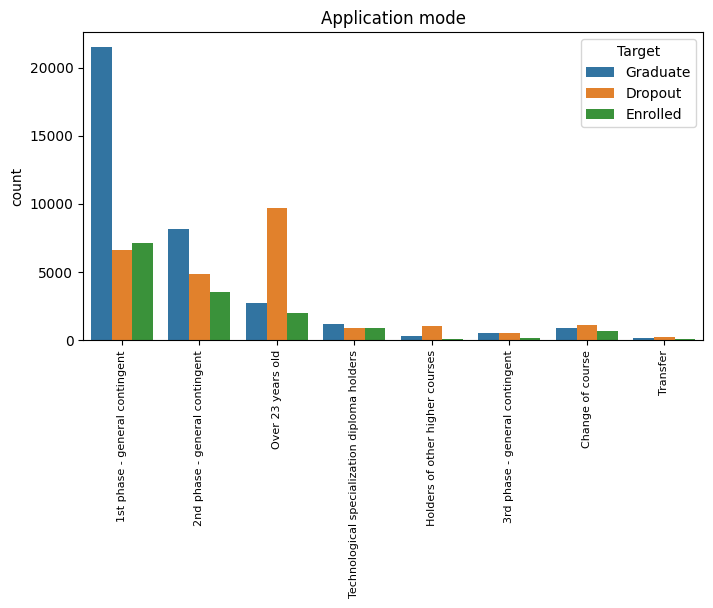

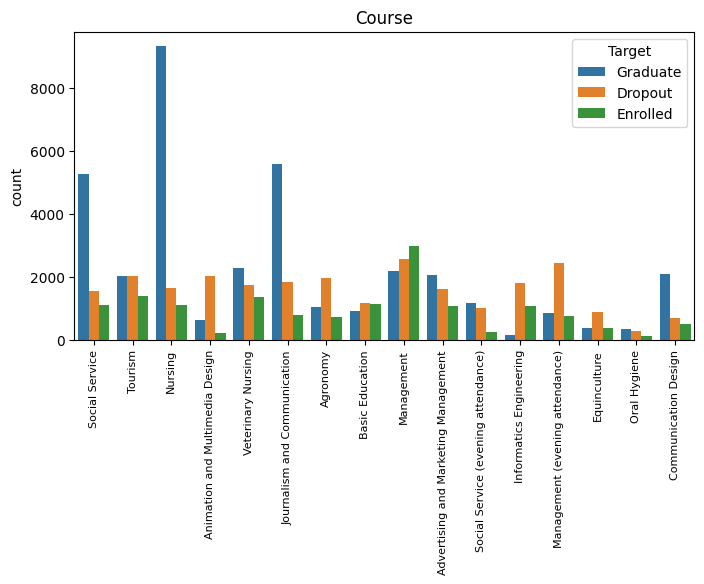

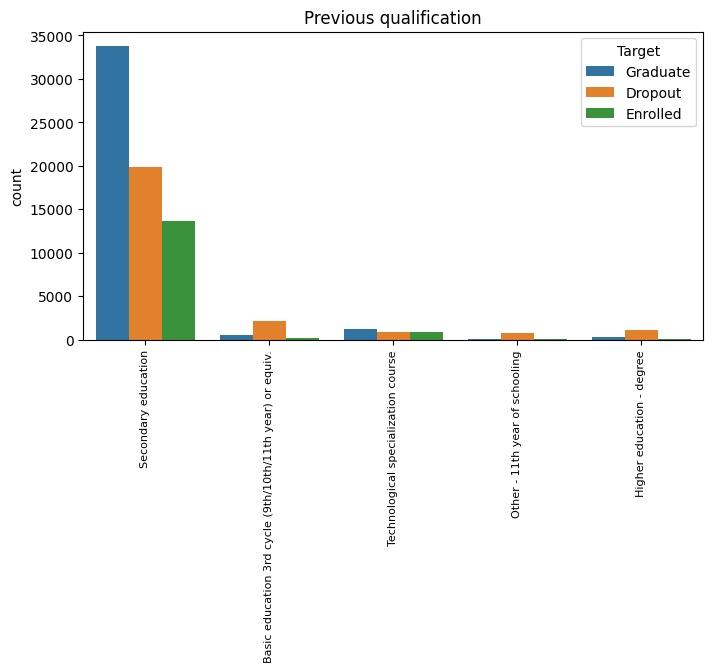

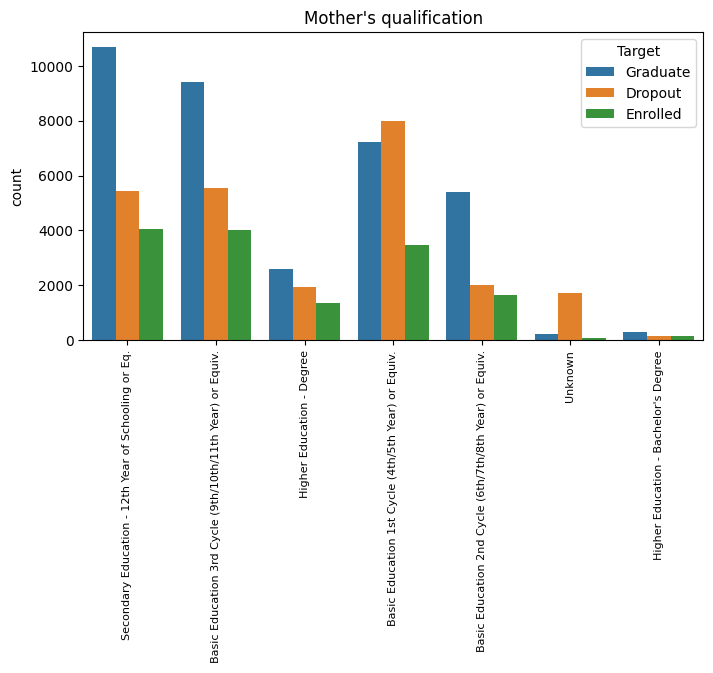

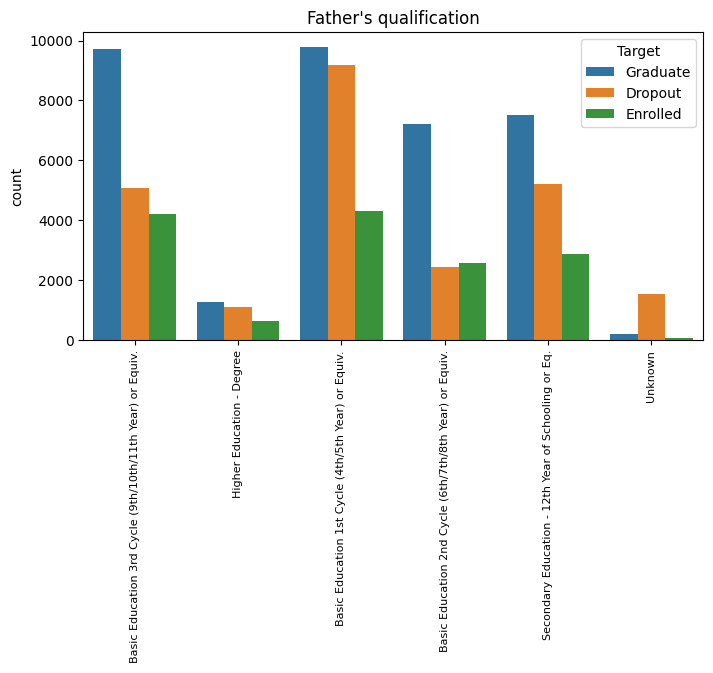

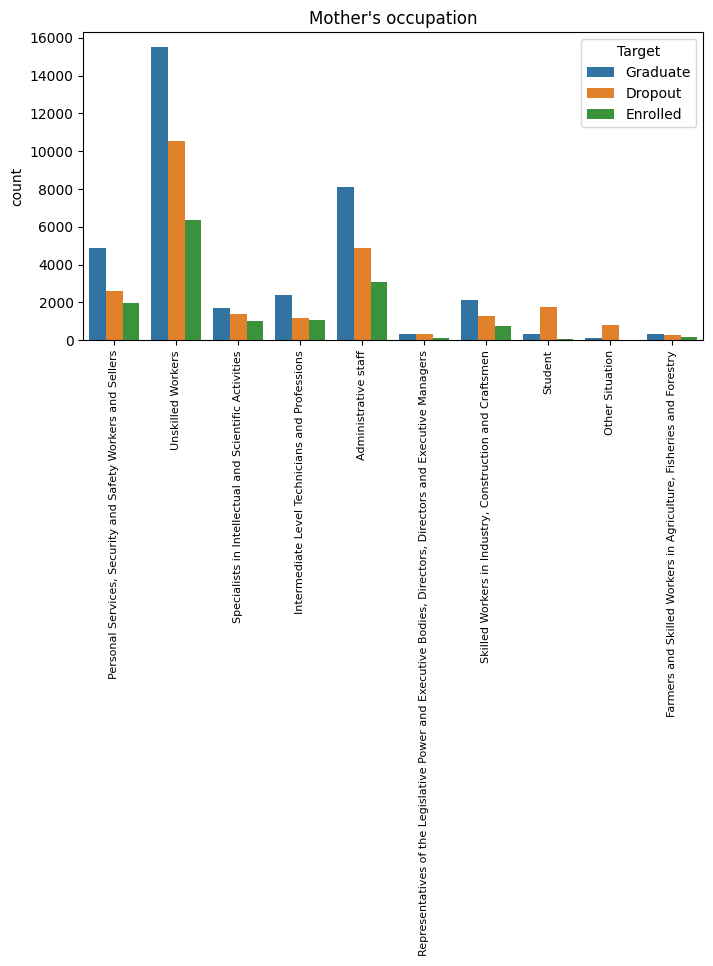

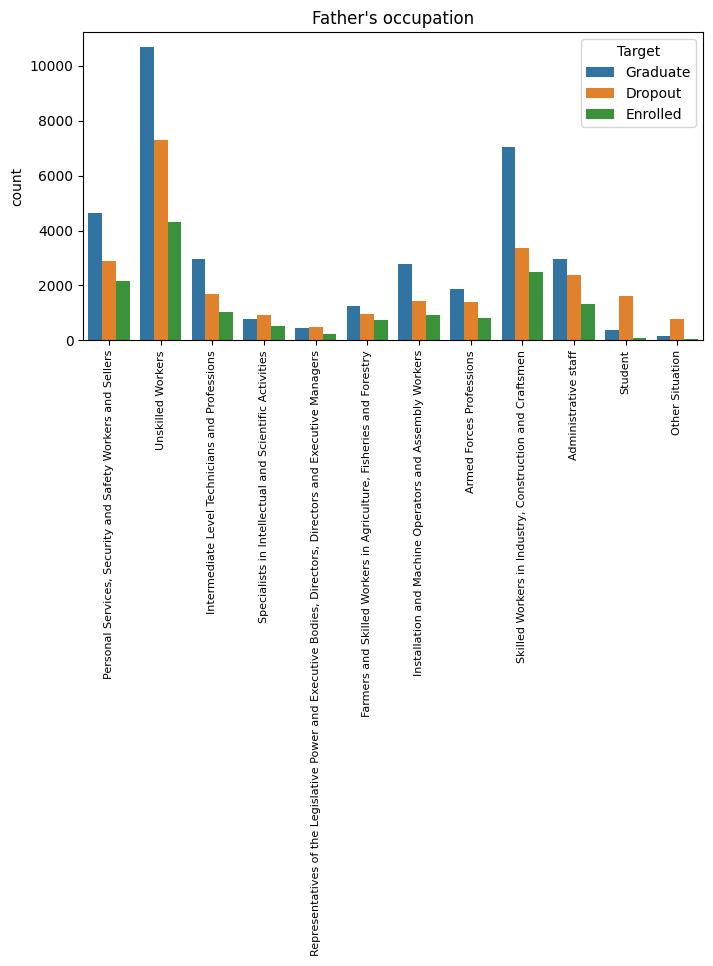

In [15]:
for var in categorical_features_large:
    if 'previous qualification' == var.lower():
        plot_category_distribution(data, var, var, previous_qualification_mapping)
    elif 'course' in var.lower():
        plot_category_distribution(data, var, var, course_mapping)
    elif 'qualification' in var.lower():
        plot_category_distribution(data, var, var, qualification_mapping)
    elif 'application mode' in var.lower():
        plot_category_distribution(data, var, var, application_mode_mapping)
    else:
        plot_category_distribution(data, var, var, occupation_mapping)

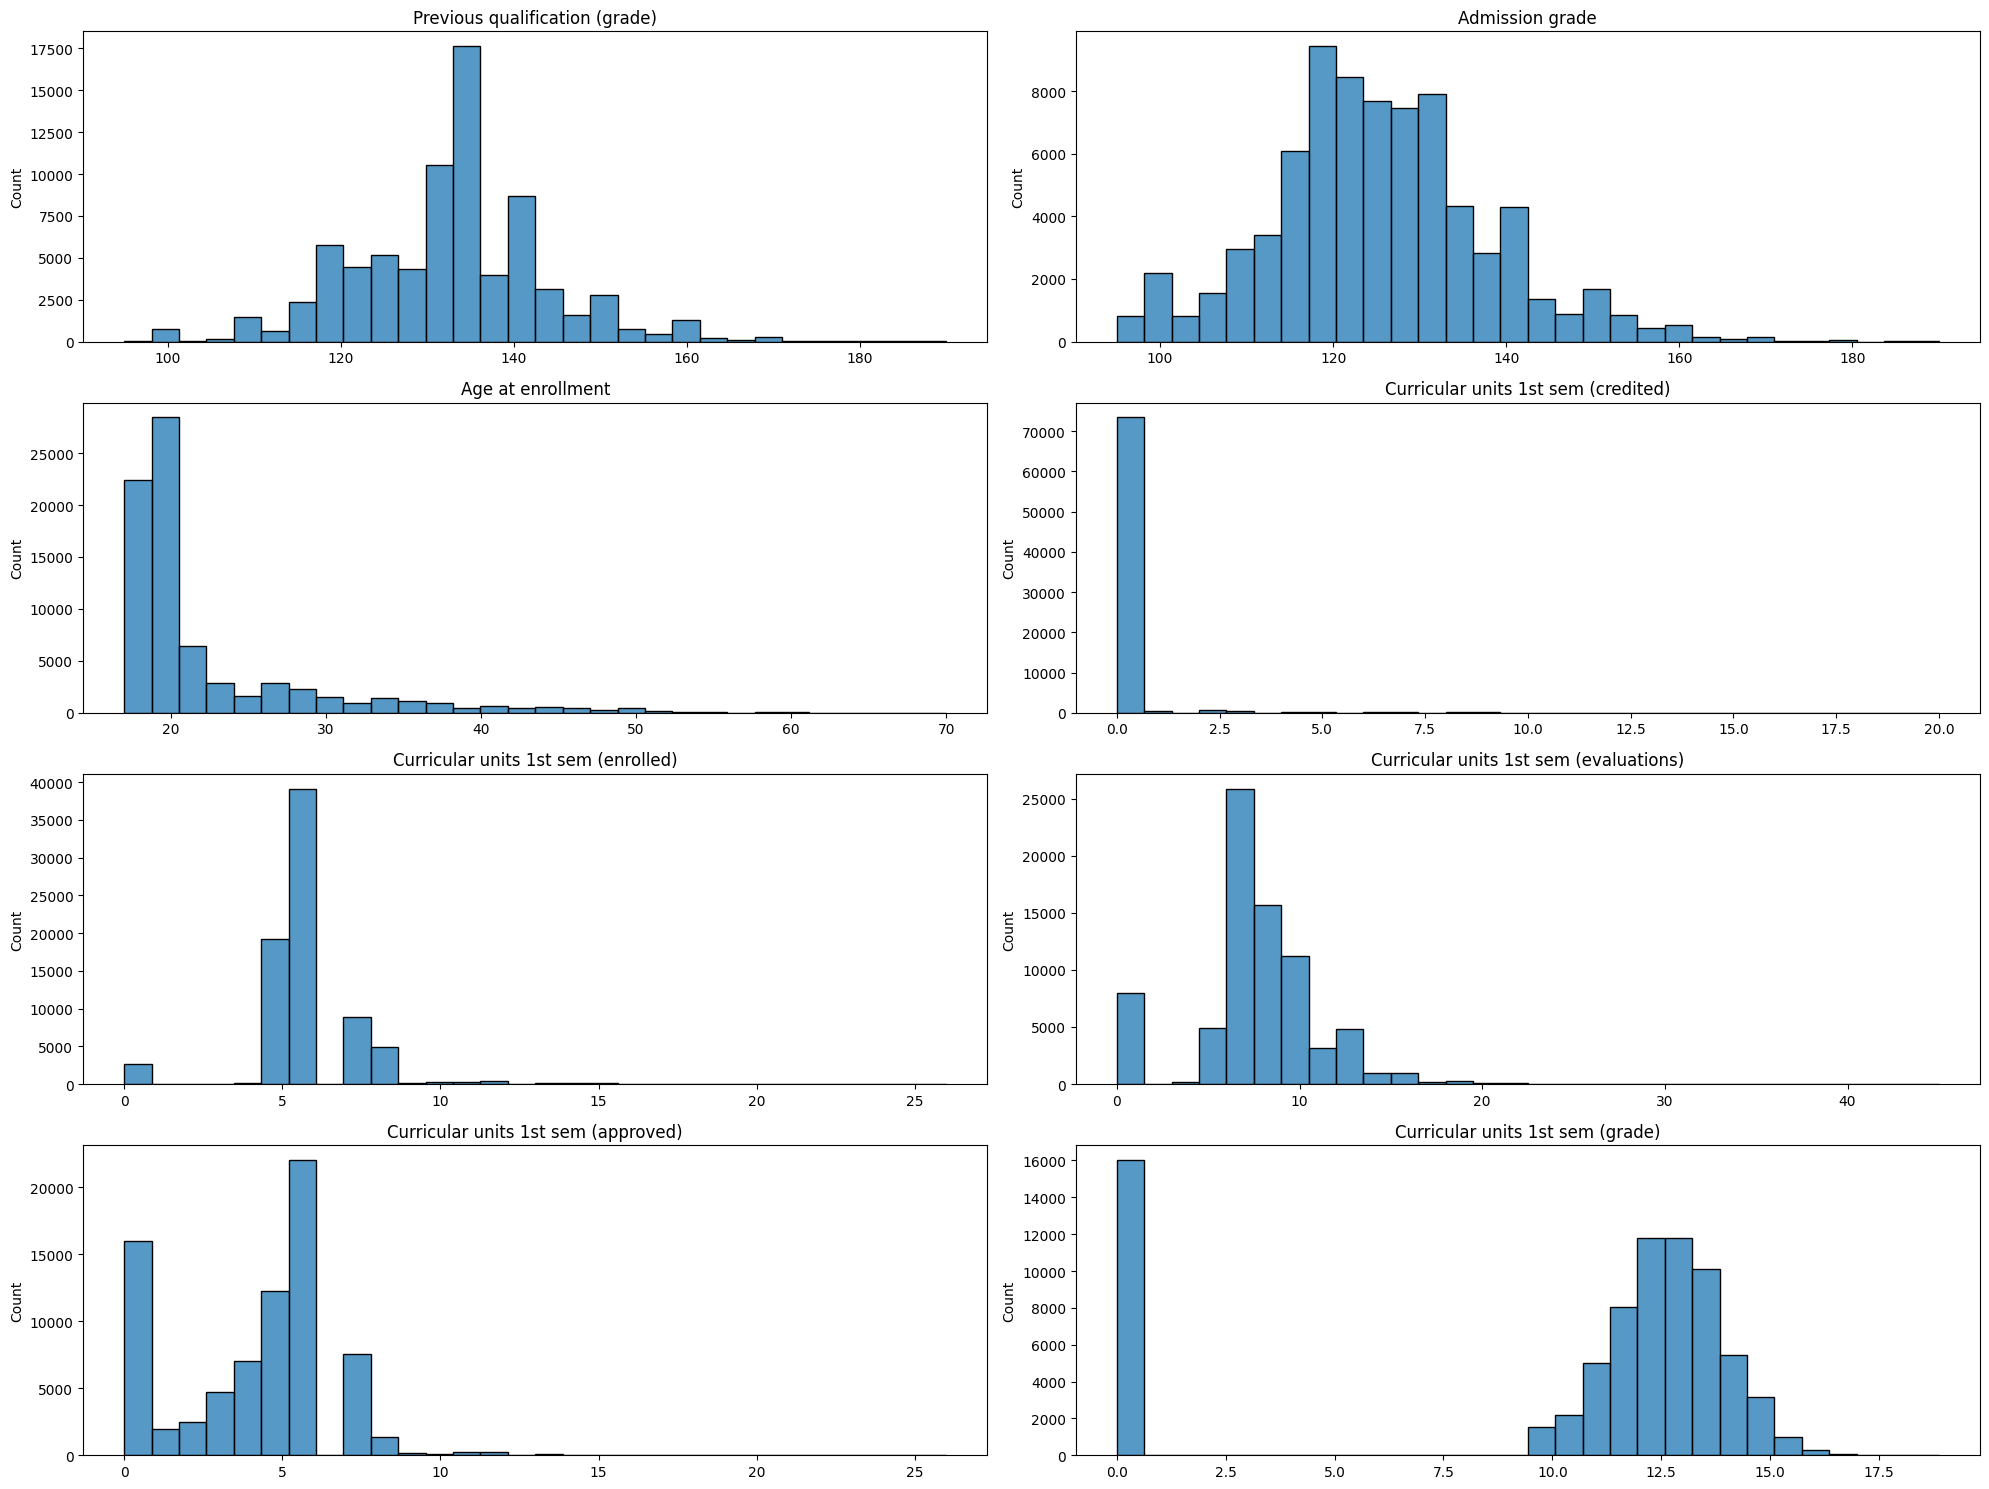

In [16]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(num_variables[:8], 1):
    plt.subplot(4, 2, i)
    sns.histplot(data[feature], kde=False, bins=30)
    plt.title(feature)
    plt.xlabel('')
plt.tight_layout()
plt.show()

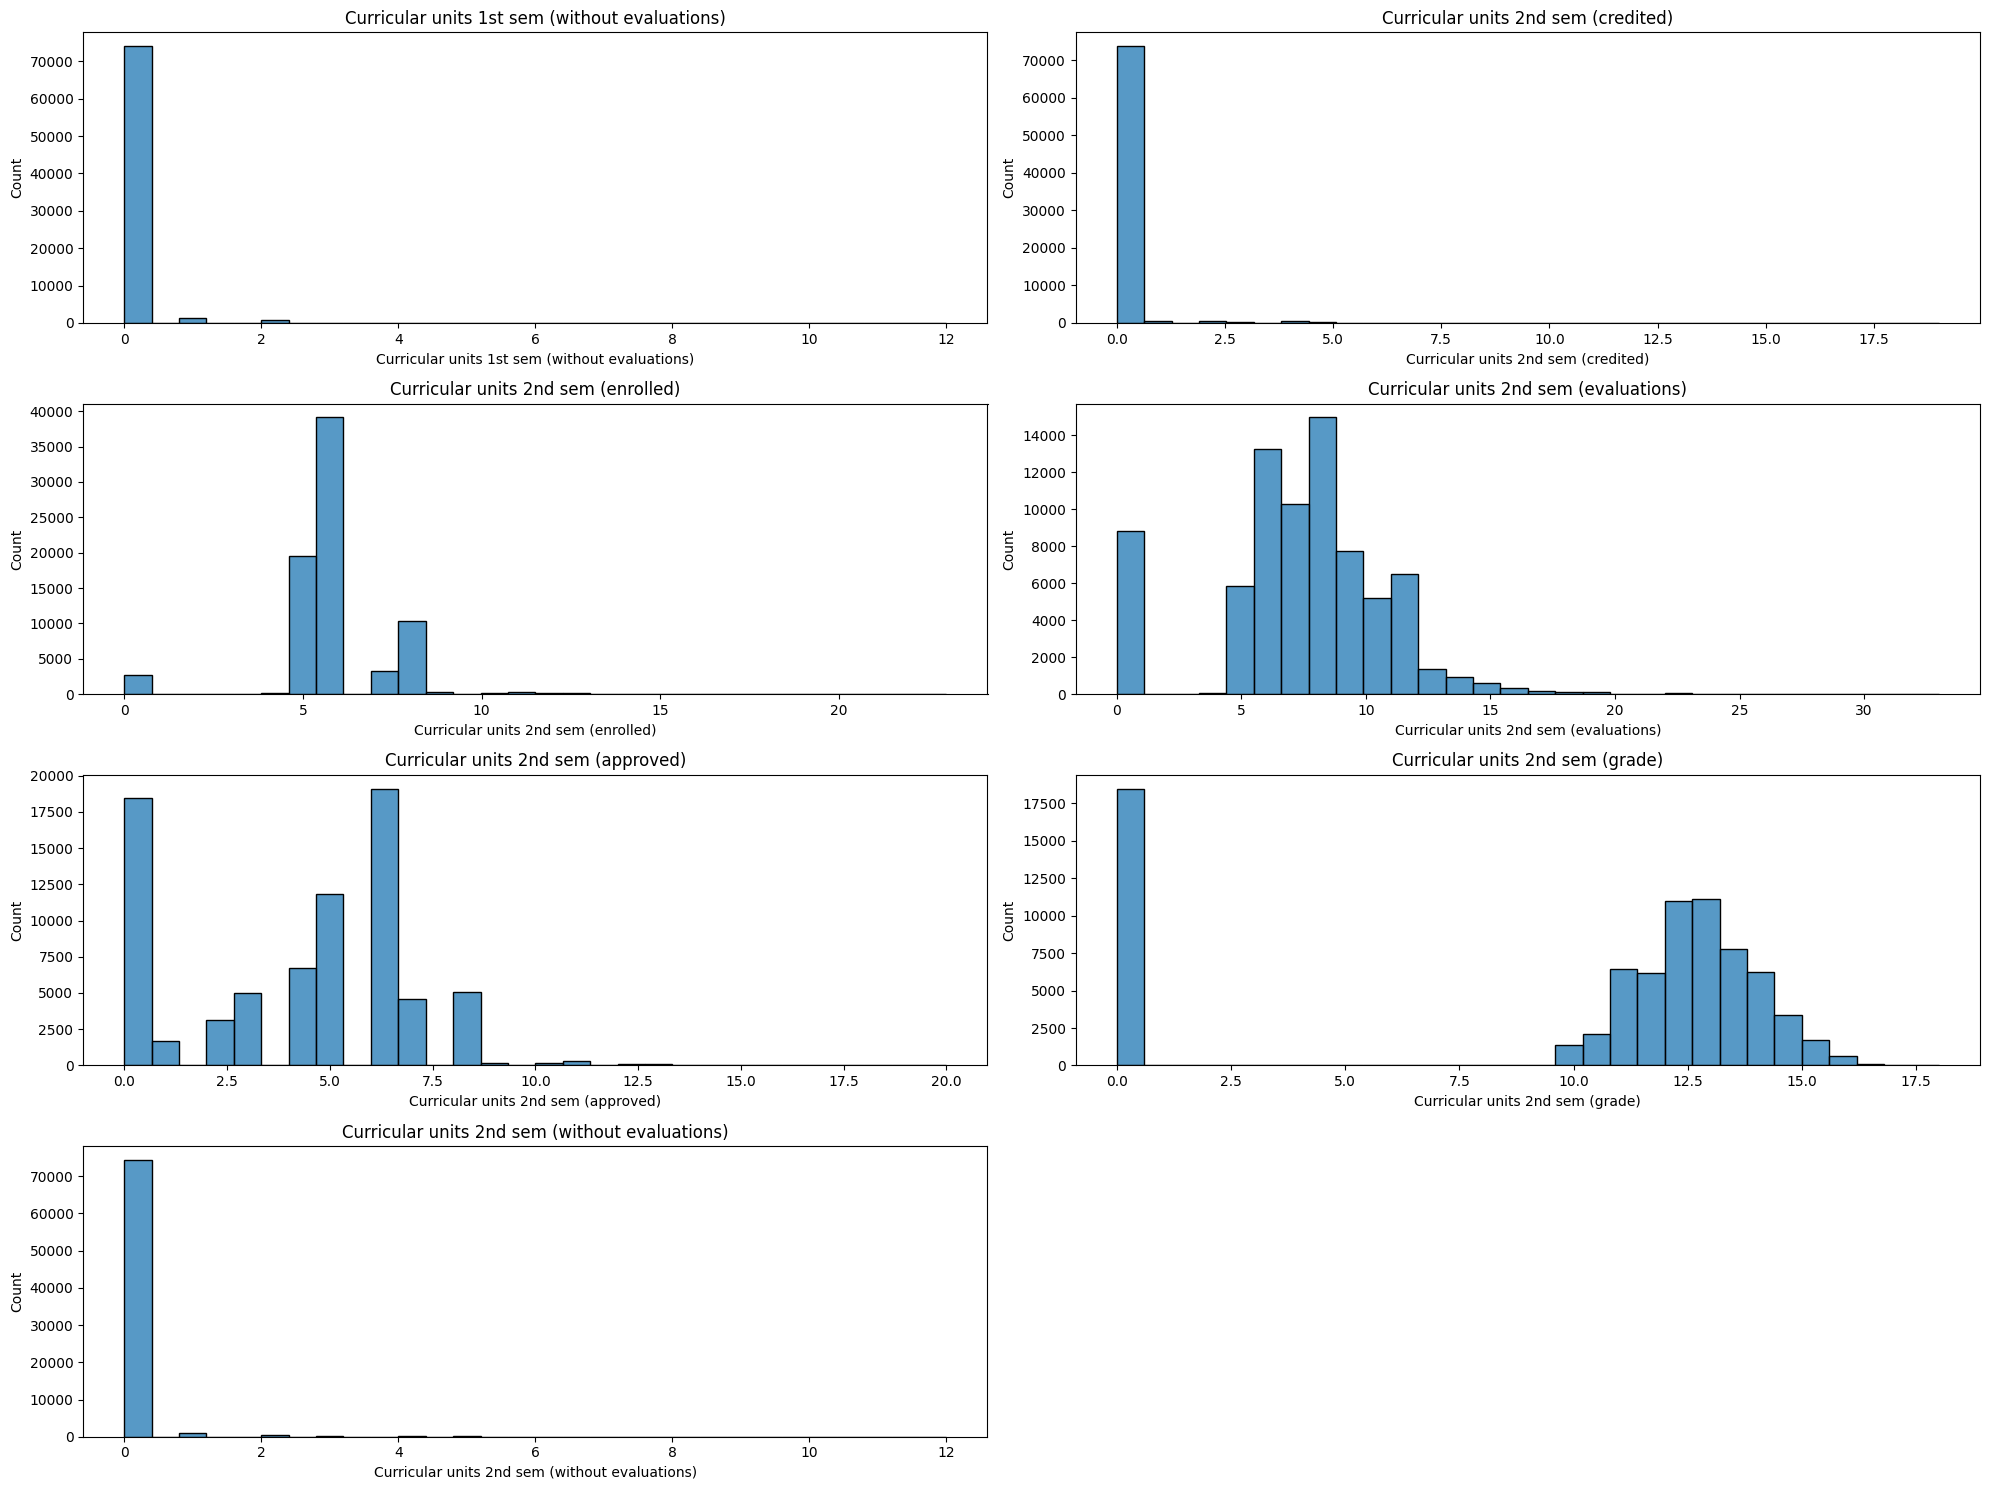

In [17]:
plt.figure(figsize=(20, 15))
for i, feature in enumerate(num_variables[8:-3], 1):
    plt.subplot(4, 2, i)
    sns.histplot(data[feature], kde=False, bins=30)
    plt.title(feature)
plt.tight_layout()
plt.show()

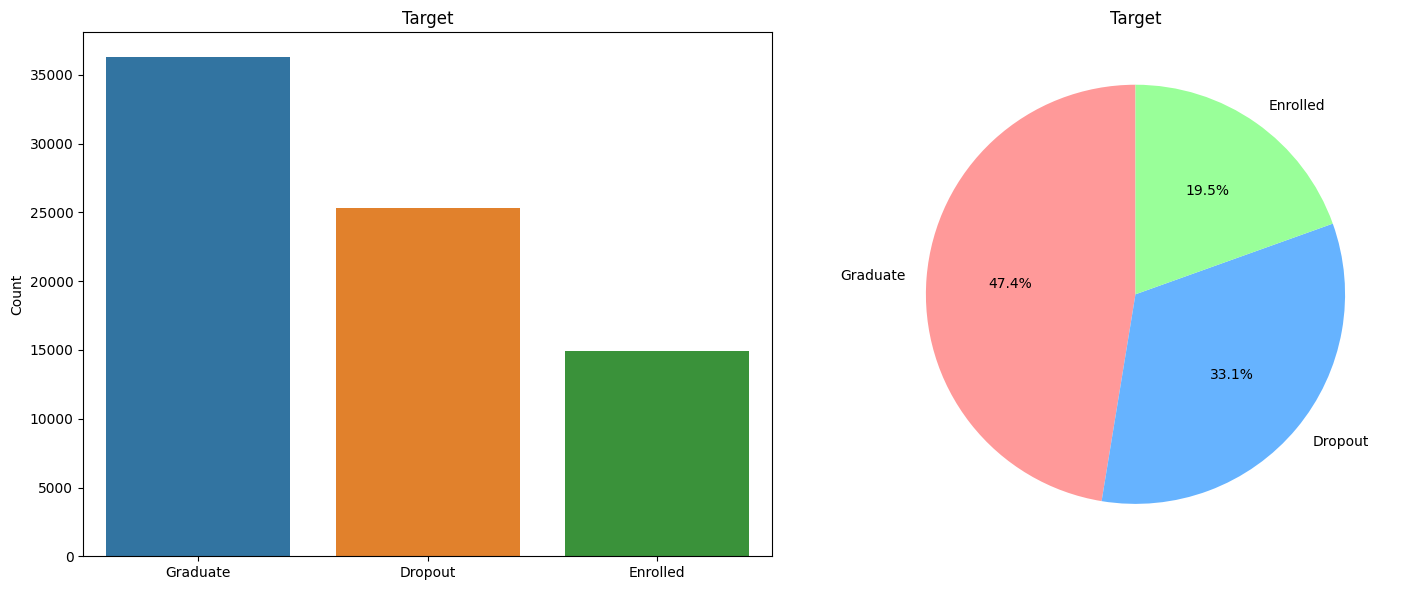

In [18]:
# Countplot for Target variable
plt.figure(figsize=(15, 6))

plt.subplot(1, 2, 1)
sns.countplot(data=data, x='Target')
plt.title('Target')
plt.xlabel('')
plt.ylabel('Count')

# Pie chart for Target variable
plt.subplot(1, 2, 2)
data['Target'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=['#ff9999','#66b3ff','#99ff99'])
plt.title('Target')
plt.ylabel('')

plt.tight_layout()
plt.show()

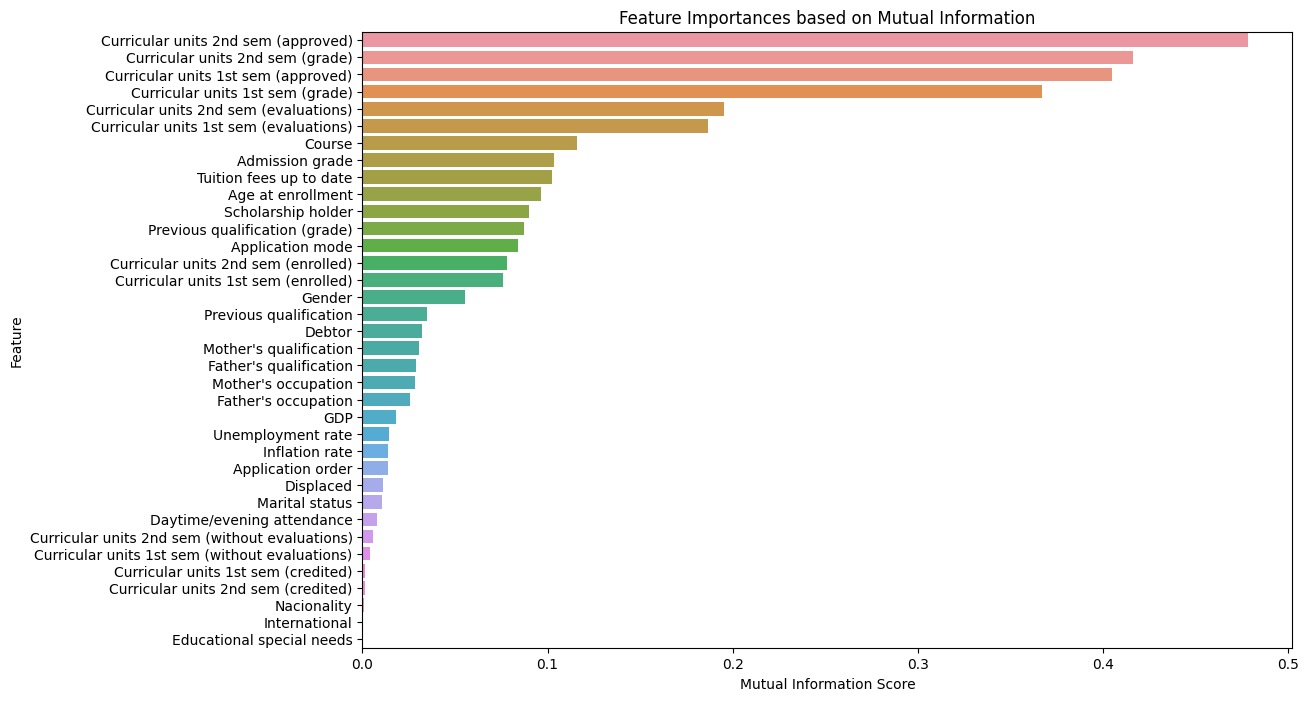

In [19]:
from sklearn.feature_selection import mutual_info_classif

X = data.drop(['Target', 'id'], axis=1)
y = data['Target']

y = y.astype('category').cat.codes

# Calculate mutual information
mi_scores = mutual_info_classif(X, y, discrete_features=[X[col].dtype == 'int64' for col in X.columns], random_state=0)

mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)

# Plot the mutual information scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information', y='Feature', data=mi_scores_df)
plt.title('Feature Importances based on Mutual Information')
plt.xlabel('Mutual Information Score')
plt.ylabel('Feature')
plt.show()

In [20]:
def get_cv_results(model, label, train, target, features, params={}, ensemble=False):
    
    X_train = train[features]
    y_train = target
    
    val_scores = [] 
    print(f'{label} Cross-Validation Results\n')
    
    for fold, (train_idx, val_idx) in enumerate(cv_kfold.split(X_train, y_train)):
        X_fold_train = X_train.iloc[train_idx]
        y_fold_train = y_train.iloc[train_idx]
        X_val = X_train.iloc[val_idx]
        y_val = y_train.iloc[val_idx]
        
        if ensemble:
            clf = model
        else:
            # Model initialization and training
            clf = model(**params)
        
        clf.fit(X_fold_train, y_fold_train)
        
        # Predict
        y_pred_trn = clf.predict(X_fold_train)
        y_pred_val = clf.predict(X_val)
        train_acc = accuracy_score(y_fold_train, y_pred_trn)
        val_acc = accuracy_score(y_val, y_pred_val)
        print(f"Fold: {fold}, Train Accuracy: {train_acc:.5f}, Val Accuracy: {val_acc:.5f}")
        
        val_scores.append(val_acc)

    # Calculate the average validation score
    average_val_accuracy = np.mean(val_scores)
    print("\nAverage Validation Accuracy:", average_val_accuracy)

    return clf, average_val_accuracy

In [21]:
def plot_feature_importances(model, train_set):
    fig = plt.figure(figsize=(10, 6))

    sorted_idx = model.feature_importances_.argsort()
    sns.barplot(y = train_set.columns[sorted_idx], x = model.feature_importances_[sorted_idx])
    plt.xlabel('Model Feature Importance')
    plt.ylabel('Feature')
    plt.yticks(fontsize=8)
    plt.show()

In [22]:
def get_preprocessed_data(train, test, categorical_variables, scale=False):
    train = train.copy()
    test = test.copy()
    
    target_label_encoder = LabelEncoder()
    train['Target'] = target_label_encoder.fit_transform(train['Target'])
    
    for var in categorical_variables:
        le = LabelEncoder()

        values = set(list(train[var].unique()) + list(test[var].unique()))
        le.fit(list(values))

        train[var] = le.transform(train[var])
        test[var] = le.transform(test[var])
        
    if scale:
        
        for var in data.columns:
            if var not in ['Target', 'id']:
                scaler = StandardScaler()
                train[var] = scaler.fit_transform(train[var].values.reshape(-1, 1))
                test[var] = scaler.transform(test[var].values.reshape(-1, 1))
    
    return train, test, target_label_encoder

In [23]:
data = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')

In [24]:
cat_variables, categorical_features_large, num_variables = get_variable_groups(data)

In [25]:
data, test, target_label_encoder = get_preprocessed_data(data, test, cat_variables + categorical_features_large, scale=True)

In [26]:
train_set = data.drop(['Target', 'id'], axis=1)
target = data['Target']

In [27]:
cv_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [28]:
xgb_model, xgb_mean_accuracy = get_cv_results(XGBClassifier, 'XGBoost', train_set, target, train_set.columns, {'device': 'cuda'})

XGBoost Cross-Validation Results

Fold: 0, Train Accuracy: 0.87817, Val Accuracy: 0.82710
Fold: 1, Train Accuracy: 0.87794, Val Accuracy: 0.82933
Fold: 2, Train Accuracy: 0.87834, Val Accuracy: 0.83612
Fold: 3, Train Accuracy: 0.87969, Val Accuracy: 0.82462
Fold: 4, Train Accuracy: 0.87872, Val Accuracy: 0.83377
Fold: 5, Train Accuracy: 0.87779, Val Accuracy: 0.83246
Fold: 6, Train Accuracy: 0.87932, Val Accuracy: 0.83468
Fold: 7, Train Accuracy: 0.87879, Val Accuracy: 0.82031
Fold: 8, Train Accuracy: 0.87758, Val Accuracy: 0.83728
Fold: 9, Train Accuracy: 0.87885, Val Accuracy: 0.83362

Average Validation Accuracy: 0.8309287884565311


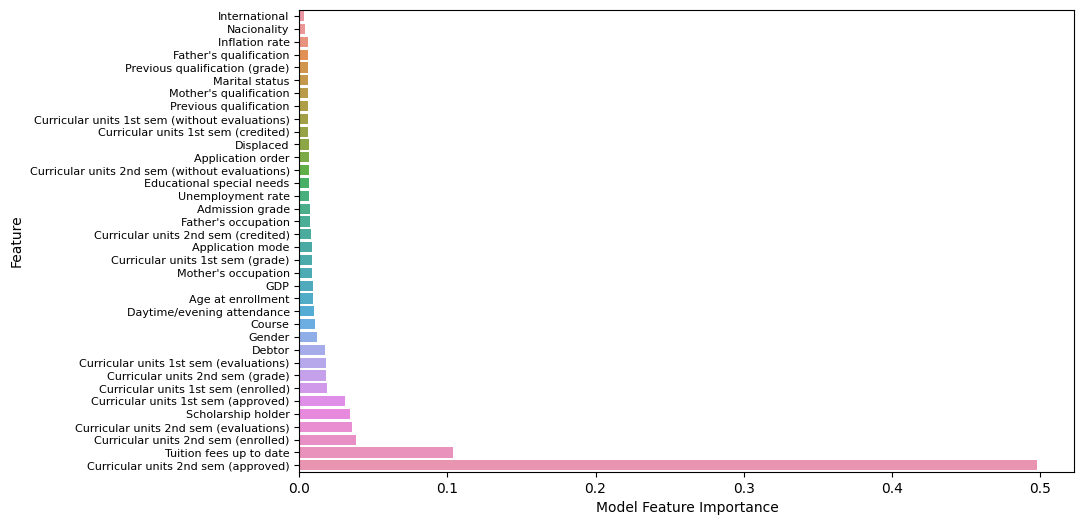

In [29]:
plot_feature_importances(xgb_model, train_set)

In [30]:
cat_model, cat_mean_accuracy = get_cv_results(CatBoostClassifier, 'CatBoost', train_set, target,
                                              train_set.columns, {'verbose': 0, 'allow_writing_files':False, 'task_type':"GPU"})

CatBoost Cross-Validation Results

Fold: 0, Train Accuracy: 0.87663, Val Accuracy: 0.83168
Fold: 1, Train Accuracy: 0.87702, Val Accuracy: 0.83050
Fold: 2, Train Accuracy: 0.87637, Val Accuracy: 0.83312
Fold: 3, Train Accuracy: 0.87746, Val Accuracy: 0.82554
Fold: 4, Train Accuracy: 0.87695, Val Accuracy: 0.83455
Fold: 5, Train Accuracy: 0.87707, Val Accuracy: 0.83142
Fold: 6, Train Accuracy: 0.87699, Val Accuracy: 0.83612
Fold: 7, Train Accuracy: 0.87808, Val Accuracy: 0.82240
Fold: 8, Train Accuracy: 0.87634, Val Accuracy: 0.83741
Fold: 9, Train Accuracy: 0.87652, Val Accuracy: 0.82983

Average Validation Accuracy: 0.8312554526011688


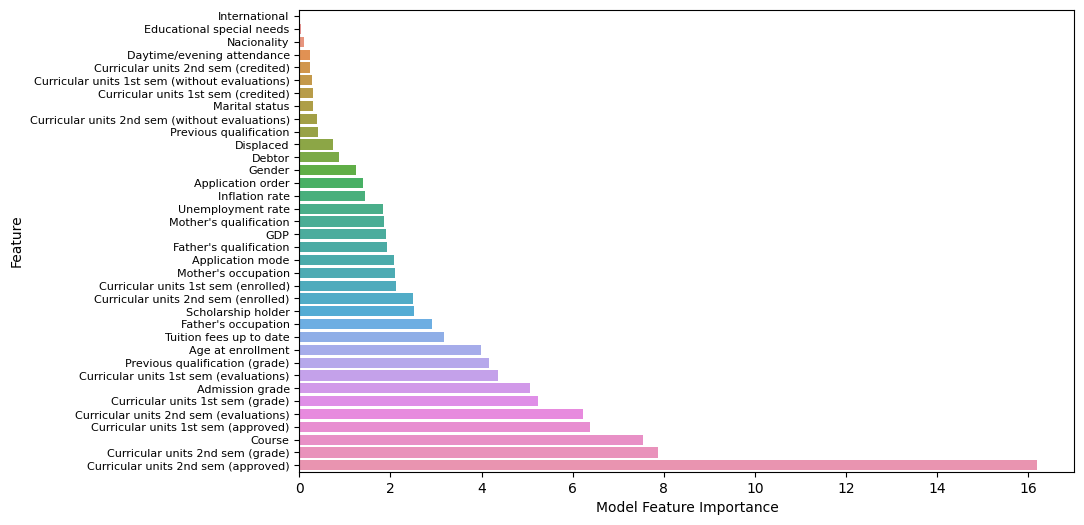

In [31]:
plot_feature_importances(cat_model, train_set)

In [32]:
lgb_clf, lgbm_mean_accuracy = get_cv_results(LGBMClassifier, 'LightGBM', train_set, target, 
                                             train_set.columns, {'verbose': -1, 'device':'gpu'})

LightGBM Cross-Validation Results



1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.
1 warning generated.


Fold: 0, Train Accuracy: 0.84984, Val Accuracy: 0.82671
Fold: 1, Train Accuracy: 0.84913, Val Accuracy: 0.82998
Fold: 2, Train Accuracy: 0.84869, Val Accuracy: 0.83677
Fold: 3, Train Accuracy: 0.84997, Val Accuracy: 0.82593
Fold: 4, Train Accuracy: 0.84940, Val Accuracy: 0.83455
Fold: 5, Train Accuracy: 0.84935, Val Accuracy: 0.83285
Fold: 6, Train Accuracy: 0.84817, Val Accuracy: 0.83429
Fold: 7, Train Accuracy: 0.84971, Val Accuracy: 0.82188
Fold: 8, Train Accuracy: 0.84753, Val Accuracy: 0.83924
Fold: 9, Train Accuracy: 0.84874, Val Accuracy: 0.83336

Average Validation Accuracy: 0.831556097645296


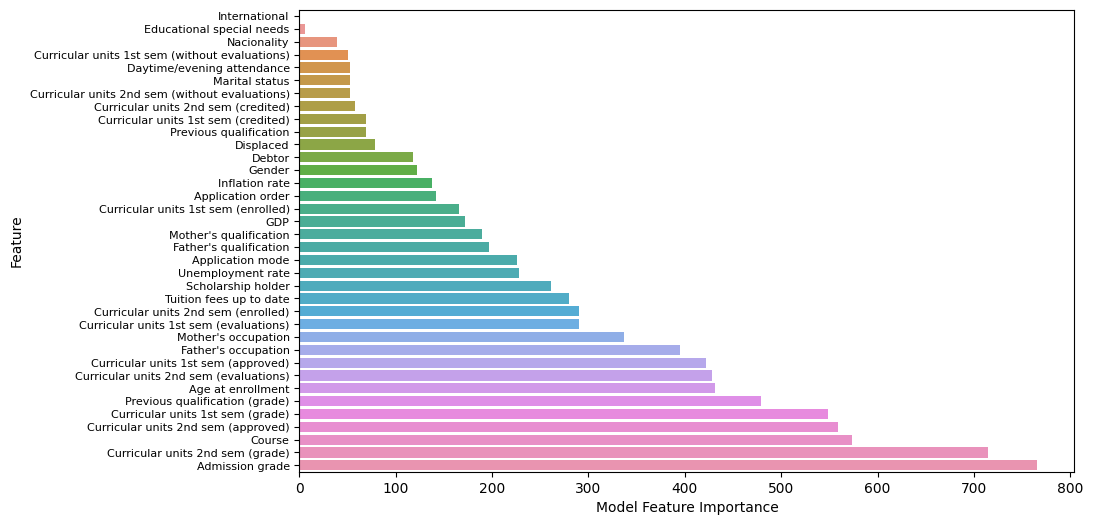

In [33]:
plot_feature_importances(lgb_clf, train_set)

In [34]:
data = pd.read_csv('/kaggle/input/playground-series-s4e6/train.csv')
test = pd.read_csv('/kaggle/input/playground-series-s4e6/test.csv')

In [35]:
cat_variables, categorical_features_large, num_variables = get_variable_groups(data)

In [36]:
# Defining high education levels
high_education_levels = {2, 3, 4, 5, 40, 41, 42, 43, 44}

data['Parent_High_Education'] = data.apply(
    lambda row: 1 if (row["Mother's qualification"] in high_education_levels or row["Father's qualification"] in high_education_levels) else 0,
    axis=1
)

test['Parent_High_Education'] = test.apply(
    lambda row: 1 if (row["Mother's qualification"] in high_education_levels or row["Father's qualification"] in high_education_levels) else 0,
    axis=1
)

cat_variables.append('Parent_High_Education')

In [37]:
# Define occupation level categories
high_level_occupations = {1, 2, 10, 122, 123, 125}
medium_level_occupations = {3, 4, 131, 132, 134, 141, 143, 144}
low_level_occupations = {5, 6, 7, 8, 9, 90, 191, 192, 193, 194}

def determine_occupation_level(row):
    mother_occ = row["Mother's occupation"]
    father_occ = row["Father's occupation"]
    if mother_occ in high_level_occupations or father_occ in high_level_occupations:
        return 3
    elif mother_occ in medium_level_occupations or father_occ in medium_level_occupations:
        return 2
    elif mother_occ in low_level_occupations or father_occ in low_level_occupations:
        return 1
    else:
        return 0

data['Parent_Occupation_Level'] = data.apply(determine_occupation_level, axis=1)
test['Parent_Occupation_Level'] = test.apply(determine_occupation_level, axis=1)

cat_variables.append('Parent_Occupation_Level')

In [38]:
# Calculate course popularity
course_popularity = data['Course'].value_counts()
data['Course_Popularity'] = data['Course'].map(course_popularity)
test['Course_Popularity'] = test['Course'].map(course_popularity)

# Calculate course success rate
course_success_rate = data[data['Target'] == 'Graduate']['Course'].value_counts() / data['Course'].value_counts()
data['Course_Success_Rate'] = data['Course'].map(course_success_rate)
test['Course_Success_Rate'] = test['Course'].map(course_success_rate)

# Calculate course dropout rate
course_dropout_rate = data[data['Target'] == 'Dropout']['Course'].value_counts() / data['Course'].value_counts()
data['Course_Dropout_Rate'] = data['Course'].map(course_dropout_rate)
test['Course_Dropout_Rate'] = test['Course'].map(course_dropout_rate)

In [39]:
health_courses = [9500, 9085, 9556, 33]
engineering_courses = [9119, 9070, 171]
management_courses = [9147, 9670, 9254, 9991, 8014]
social_sciences_courses = [9238, 9773, 9853, 9130]

data['Health_Course'] = data['Course'].apply(lambda x: 1 if x in health_courses else 0)
test['Health_Course'] = test['Course'].apply(lambda x: 1 if x in health_courses else 0)

data['Engineering_Course'] = data['Course'].apply(lambda x: 1 if x in engineering_courses else 0)
test['Engineering_Course'] = test['Course'].apply(lambda x: 1 if x in engineering_courses else 0)

data['Management_Course'] = data['Course'].apply(lambda x: 1 if x in management_courses else 0)
test['Management_Course'] = test['Course'].apply(lambda x: 1 if x in management_courses else 0)

data['Social_Sciences_Course'] = data['Course'].apply(lambda x: 1 if x in social_sciences_courses else 0)
test['Social_Sciences_Course'] = test['Course'].apply(lambda x: 1 if x in social_sciences_courses else 0)

In [40]:
data, test, target_label_encoder = get_preprocessed_data(data, test, cat_variables + categorical_features_large, scale=True)

train_set = data.drop(['Target', 'id'], axis=1)
target = data['Target']

In [41]:
xgb_model, xgb_mean_accuracy = get_cv_results(XGBClassifier, 'XGBoost & Feature Engineering -', train_set, target, train_set.columns, {'device': 'cuda'})

XGBoost & Feature Engineering - Cross-Validation Results

Fold: 0, Train Accuracy: 0.87969, Val Accuracy: 0.82919
Fold: 1, Train Accuracy: 0.88027, Val Accuracy: 0.83285
Fold: 2, Train Accuracy: 0.88023, Val Accuracy: 0.83599
Fold: 3, Train Accuracy: 0.88042, Val Accuracy: 0.82567
Fold: 4, Train Accuracy: 0.88046, Val Accuracy: 0.83168
Fold: 5, Train Accuracy: 0.87885, Val Accuracy: 0.83429
Fold: 6, Train Accuracy: 0.87914, Val Accuracy: 0.83442
Fold: 7, Train Accuracy: 0.87898, Val Accuracy: 0.82083
Fold: 8, Train Accuracy: 0.87941, Val Accuracy: 0.83584
Fold: 9, Train Accuracy: 0.88017, Val Accuracy: 0.83440

Average Validation Accuracy: 0.8315168614634659


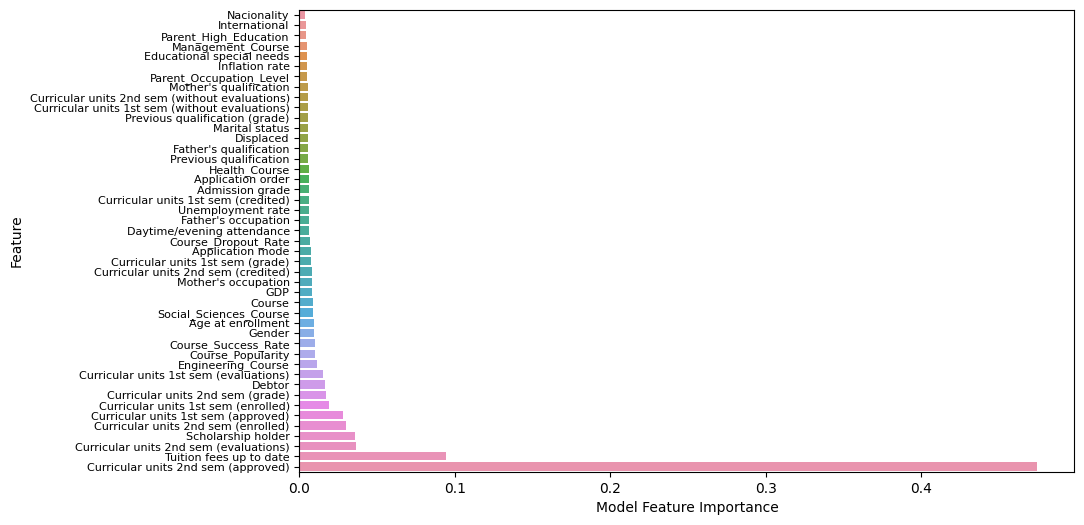

In [42]:
plot_feature_importances(xgb_model, train_set)

In [43]:
train_set = data.drop(['Target', 'id'], axis=1)
target = data['Target']

In [44]:
X_train, X_val, y_train, y_val = train_test_split(train_set, target, test_size=0.20, random_state=1)

In [45]:
# def objective(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0, 1),
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
#         'subsamples': trial.suggest_float('subsamples', 0, 1),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
#         'gamma': trial.suggest_float('gamma', 0, 1)
#     }
    
#     model = XGBClassifier(**params, 
#                           verbose= False,
#                           device='cuda',
#                           objective='multi:softmax',
#                           eval_metric='mlogloss')

#     model.fit(X_train, y_train, verbose=False)

#     y_pred = model.predict(X_val)
#     score = accuracy_score(y_val, y_pred)
#     return score

In [46]:
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=100)

In [47]:
# best_params_XGB = study.best_params
# best_params_XGB

In [48]:
best_params_XGB = {'learning_rate': 0.1109767592634639,
                 'max_depth': 6,
                 'n_estimators': 976,
                 'subsamples': 0.15903496767246944,
                 'colsample_bytree': 0.17528294207116227,
                 'reg_alpha': 0.4952497020602008,
                 'reg_lambda': 0.8765400381191983,
                 'gamma': 0.49623176997900964}

In [49]:
xgb_clf_best = XGBClassifier(**best_params_XGB, verbose=False,
                             device='cuda',
                             objective='multi:softmax',
                             eval_metric='mlogloss')

xgb_clf_best.fit(X_train, y_train)

accuracy_score(y_val, xgb_clf_best.predict(X_val))

0.8344223732357554

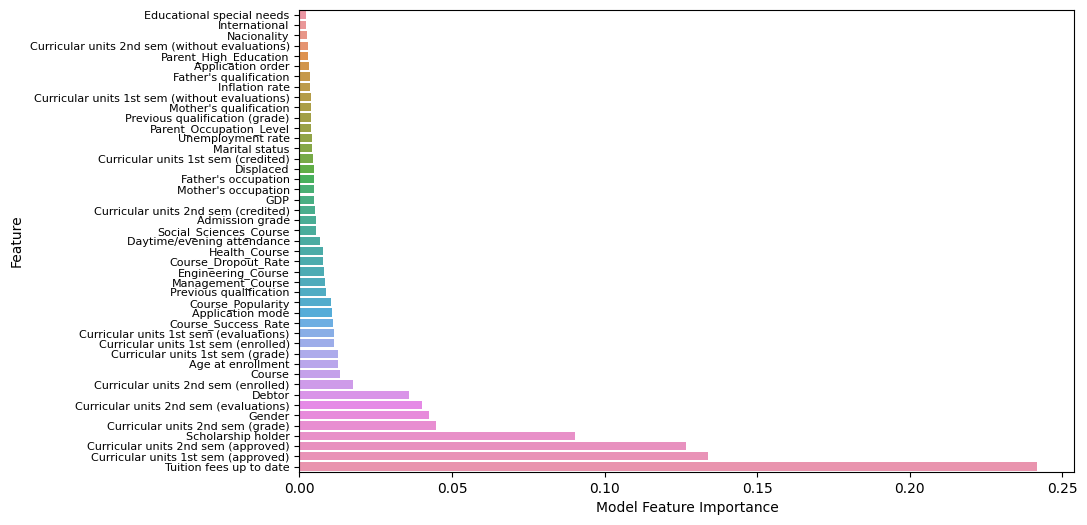

In [50]:
plot_feature_importances(xgb_clf_best, train_set)

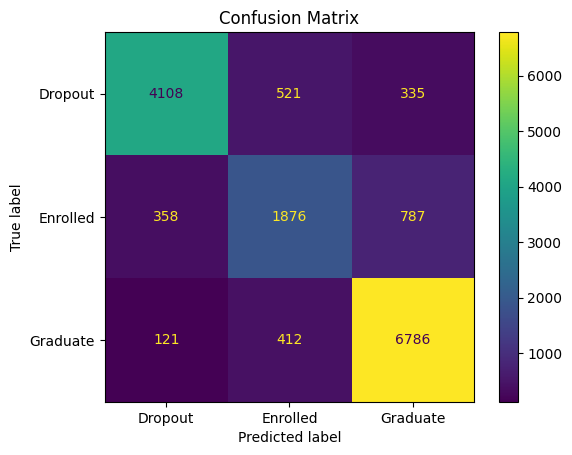

In [51]:
confusion_mat = confusion_matrix(y_val, xgb_clf_best.predict(X_val))

ConfusionMatrixDisplay(confusion_mat, display_labels=target_label_encoder.classes_.tolist()).plot()
plt.title("Confusion Matrix")
plt.show()

In [52]:
# def objective2(trial):
#     params = {
#         'learning_rate': trial.suggest_float('learning_rate', 0, 1),
#         'max_depth': trial.suggest_int('max_depth', 4, 10),
#         'n_estimators': trial.suggest_int('n_estimators', 500, 2000),
#         'subsamples': trial.suggest_float('subsamples', 0, 1),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
#         'reg_alpha': trial.suggest_float('reg_alpha', 0, 1),
#         'reg_lambda': trial.suggest_float('reg_lambda', 0, 1),
#         'gamma': trial.suggest_float('gamma', 0, 1)
#     }
    
#     model = LGBMClassifier(**params, 
#                           verbose= -1, 
#                           objective='multiclass',
#                           eval_metric='multi_logloss',
#                           device='gpu')

#     model.fit(X_train, y_train)

#     y_pred = model.predict(X_val)
#     score = accuracy_score(y_val, y_pred)
#     return score

In [53]:
# study2 = optuna.create_study(direction='maximize')
# study2.optimize(objective2, n_trials=100)

In [54]:
# best_params_LGBM = study2.best_params
# best_params_LGBM

In [55]:
best_params_LGBM = {'learning_rate': 0.053004845936878986,
                     'max_depth': 5,
                     'n_estimators': 1409,
                     'subsamples': 0.14281227162605073,
                     'colsample_bytree': 0.09296940842717807,
                     'reg_alpha': 0.13044638358714675,
                     'reg_lambda': 0.549877519916459,
                     'gamma': 0.6720500561927663}

In [56]:
lgbm_clf_best = LGBMClassifier(**best_params_LGBM, 
                               verbose= -1, 
                               objective='multiclass',
                               eval_metric='multi_logloss',
                               device='gpu',
                               class_weight='balanced')

lgbm_clf_best.fit(X_train, y_train)

accuracy_score(y_val, lgbm_clf_best.predict(X_val))

0.8198510193413486

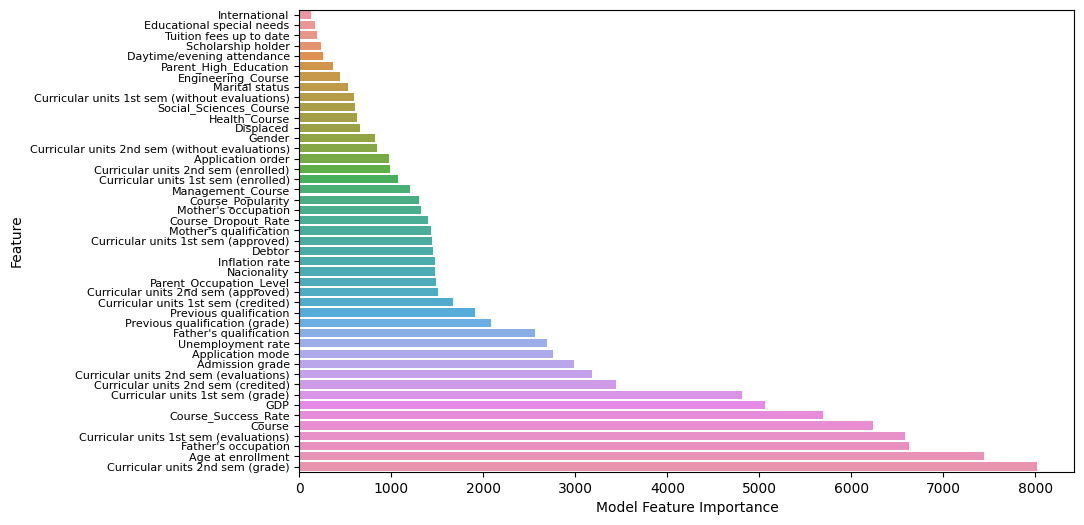

In [57]:
plot_feature_importances(lgbm_clf_best, train_set)

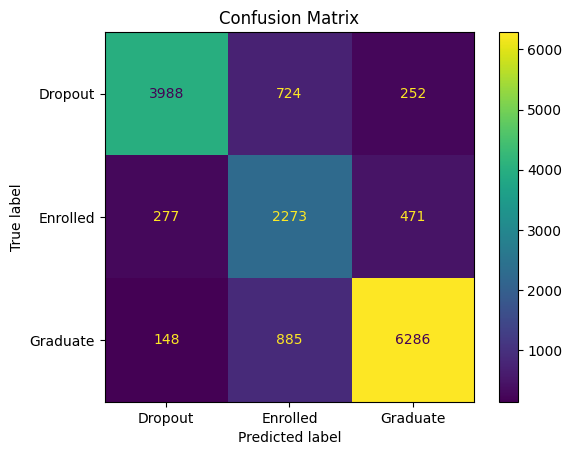

In [58]:
confusion_mat = confusion_matrix(y_val, lgbm_clf_best.predict(X_val))

ConfusionMatrixDisplay(confusion_mat, display_labels=target_label_encoder.classes_.tolist()).plot()
plt.title("Confusion Matrix")
plt.show()

In [59]:
from sklearn.ensemble import VotingClassifier

clf_xgb = XGBClassifier(**best_params_XGB, 
                        verbose=False,
                        device='cuda',
                        objective='multi:softmax',
                        eval_metric='mlogloss')

estimators = [
    ('lgbm', lgb_clf),
    ('catb', cat_model),
    ('xgb', clf_xgb)
]

clf_voting = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
clf_voting.fit(X_train, y_train)
accuracy_score(y_val, clf_voting.predict(X_val))

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:28:32] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "subsamples", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


0.8336382645060115

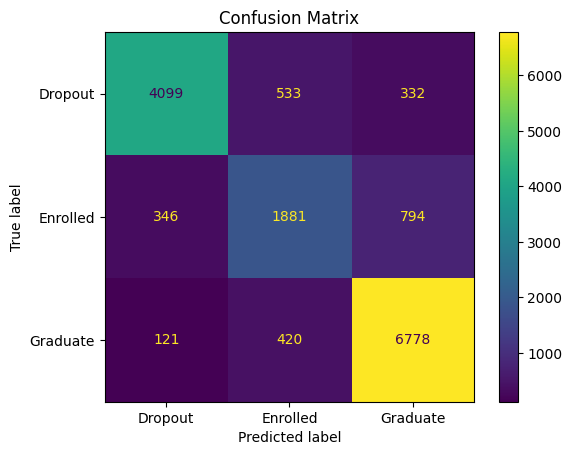

In [60]:
confusion_mat = confusion_matrix(y_val, clf_voting.predict(X_val))

ConfusionMatrixDisplay(confusion_mat, display_labels=target_label_encoder.classes_.tolist()).plot()
plt.title("Confusion Matrix")
plt.show()

In [61]:
clf_xgb = XGBClassifier(**best_params_XGB, 
                        verbose=False,
                        device='cuda',
                        objective='multi:softmax',
                        eval_metric='mlogloss')

estimators = [
    ('lgbm', lgb_clf),
    ('catb', cat_model),
    ('xgb', clf_xgb)
]

clf_voting = VotingClassifier(estimators=estimators, voting='soft', n_jobs=-1)
clf_voting.fit(train_set, target)

/opt/conda/lib/python3.10/site-packages/xgboost/core.py:160: UserWarning: [06:28:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "subsamples", "verbose" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('lgbm', LGBMClassifier(device='gpu', verbose=-1)),
                             ('catb',
                              <catboost.core.CatBoostClassifier object at 0x7e34381433d0>),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.17528294207116227,
                                            device='cuda',
                                            early_stopping_rounds=None,
                                            enable_categorical...
                                            interaction_constraints=None,
                                            learning_rate=0.1109767592634639,
                                            max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=976, n_jobs=None,
                                            num_parallel_tree=None,
                                            objective='multi:softmax', ...))],
                 n_jobs=-1, voting='soft')

In [62]:
X_test = test[train_set.columns]
y_pred = clf_voting.predict(X_test)

submission = pd.DataFrame({'id': test['id'], 'Target': target_label_encoder.inverse_transform(y_pred)})
submission.to_csv('submission.csv', index=False)

In [63]:
submission

,id,Target
0,76518,Dropout
1,76519,Graduate
2,76520,Graduate
3,76521,Graduate
4,76522,Enrolled
...,...,...
51007,127525,Dropout
51008,127526,Dropout
51009,127527,Dropout
51010,127528,Dropout
